# WEBSITE OWNERSHIP NETWORK ANALYSIS

A script to help determine who owns a website, by mapping out the entire network and finding contacts.

Realises on data in Domain BigData to draw a network of website ownership direct-links. 



### IMPORTS

In [818]:
# libraries
import requests
from bs4 import BeautifulSoup, Tag
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import networkx as nx

In [1162]:
### !!! IMPORTANT !!! ONLY WANT NON-GENERIC NODES.  'Whoisguard Protected' etc WILL MAKE THIS TOO MESSY TO COMPREHEND - AND ADD NO VALUE
### RUN THROUGH AND ADD EXTRA TERMS TO THE EXCLUDE LIST TO HELP REFINE THE SEARCH

exclude = ['abuse@namecheap.com', 'Whoisguard Inc', 'Whoisguard Protected', 'Domain Admin', 'Privacy Protect Llc (privacyprotect.org)', '\n', '+1.6613102107', 'Ddd','Domain Registries Foundation','REDACTED FOR PRIVACY','Domain Admin / This Domain Is For Sale','Perfect Privacy Llc','Data Protected Data Protected','Registration Private',\
'contact@privacyprotect.org','Contact Privacy Inc. Customer 0141346021','Domain Administrator','Domain Manager','Na','******** ********','Domains By Proxy Llc','Data Protected']


In [1163]:
# THIS IS THE CHECKLIST OF SITES THAT WE WANT TO START WITH
checklist = ['https://www.betzona.cc/',\
            'https://www.caribebet.cc/',\
            'https://www.flashbet.cc/',\
            'https://mustangbet.cc/',\
            'https://luckydog.in/',\
            'https://oceanside247.com/',\
            'https://sportsaction77.com/']

## FUNCTIONS

In [1164]:
### FOR DRAWING THE GRAPHS
# Note: the colouring conditions are hand-coded in here

G = nx.Graph()
contact_list = []

def colorGraph(height):
    
    color_map = []
    
    for node in G:
        if ".cc" in node:
            color_map.append('green')
        elif node == 'luckydog.in' or node == 'oceanside247.com':
            color_map.append('orange')            
        elif "@" in str(node) or "(at)" in str(node) or "+" in str(node):            #highlights web addresses
            color_map.append('yellow')
            contact_list.append(node)
        elif ".com" in str(node) or ".net" in str(node) or ".org" in str(node) or ".in" in str(node) or ".me" in str(node) or ".us" in str(node): 
            color_map.append('silver')
        else:
            color_map.append('blue')
            contact_list.append(node)
            
    plt.figure(1,figsize=(18,height)) 
    pos = nx.spring_layout(G,k=0.5,iterations=150)    
    nx.draw(G, pos, alpha=.6, with_labels=True, node_color=color_map, font_color="k")
    plt.show()

In [1165]:
## FOR FINDING EACH SITE'S RELEVANT REGISTRATION DETAILS, INCLUDING HISTORIC DETAILS

def DBDsites(site,s):
 
    url = "https://domainbigdata.com/" + s 
    page = requests.get(url)                                
    soup = BeautifulSoup(page.content, 'html.parser')
    
    def getInfo(idequals, dname, v1,):
        
        try:
            
            bit = soup.find(id=idequals)
            
            if v1 == 'TD1':    
                bit = bit.find_all("td")[1]
                
            if bit.find('a') != None:
                bit = bit.find("a")
                
                if dname == 'Registrant Name':
                    h = bit.get("href")
                    h = "https://domainbigdata.com" + h                    
                    identifiers_d[s]['Registrant Name URL'] = h
                    
                if dname == 'Registrant Organisation':
                    h = bit.get("href")
                    h = "https://domainbigdata.com" + h                    
                    identifiers_d[s]['Registrant Organisation URL'] = h
                    
                if dname == 'Historic Name 0':
                    h = bit.get("href")
                    h = "https://domainbigdata.com" + h                    
                    identifiers_d[s]['Historic Name 0 URL'] = h
                    
                if dname == 'Historic Org 0':
                    h = bit.get("href")
                    h = "https://domainbigdata.com" + h                    
                    identifiers_d[s]['Historic Org 0 URL'] = h 
                    
                if dname == 'Historic Name 1':
                    h = bit.get("href")
                    h = "https://domainbigdata.com" + h                    
                    identifiers_d[s]['Historic Name 1 URL'] = h
                    
                if dname == 'Historic Org 1':
                    h = bit.get("href")
                    h = "https://domainbigdata.com" + h                    
                    identifiers_d[s]['Historic Org 1 URL'] = h 
            
            bit = bit.contents[0]

        except:
            bit = None

        identifiers_d[s][dname] = bit
    
    getInfo("trRegistrantName", 'Registrant Name', 'TD1')
    getInfo('MainMaster_trRegistrantOrganization', 'Registrant Organisation', None)
    getInfo("trRegistrantEmail", 'Registrant Email', 'TD1')
    getInfo("trRegistrantTel", 'Registrant Phone', 'TD1')
    
    historical = soup.find_all(id='divRptHistoryMain')
    for n in range(0,len(historical)):        
        getInfo("trRegistrantNameInRpt", 'Historic Name ' + str(n), 'TD1')
        getInfo('MainMaster_rptWhoisHistory_trRegistrantOrganizationInRpt_' + str(n), 'Historic Org ' + str(n), 'TD1')
        getInfo('trRegistrantEmailInRpt', 'Historic Email ' + str(n), 'TD1')
        getInfo('trRegistrantAddressInRpt', 'Historic Address ' + str(n), 'TD1')
        getInfo('trRegistrantTelInRpt', 'Historic Phone ' + str(n), 'TD1')
        getInfo('trRegistrantFaxInRpt', 'Historic Fax ' + str(n), 'TD1')
              
    print(url)

In [1166]:
## ADDS HISTORY COLUMNS THAT MAY NOT HAVE BEEN NEEDED TO BE CREATED YET. ONLY NEEDED THE FIRST TIME AROUND USUALLY

def addHistCols(term):
    if 'Historic ' + term + ' 1' not in identifiersDF.columns:
        identifiersDF['Historic ' + term + ' 1'] = None
        identifiersDF['Historic ' + term + ' 1 URL'] = None


In [1167]:
## FOR ATTACHING REGISTATION INFO TO SITES IN THE GRAPH

def regNodes(field1, field2):
    
        temp = identifiersDF[[field1, field2]].dropna()
        temp = temp[temp[field2].isin(exclude) == False]
    
        for index, row in temp.iterrows():
            a = row[field1]
            b = row[field2]
            G.add_edge(a,b)

In [1168]:
### ONCE YOU ESTABLISH A SITE'S OWNER, THIS WILL FIND OUT WHAT ELSE THEY OWN

def ownerNodes(fieldURL, fieldNODE):
    
    temp = identifiersDF[[fieldURL, fieldNODE]].dropna()
    temp = temp[temp[fieldNODE].isin(exclude) == False]

    temp_d = {}
    for index, row in temp[[fieldNODE,fieldURL]].dropna().iterrows():
            a = row[fieldURL]
            b = row[fieldNODE]
            temp_d[a] = b
            
    def DBDowner(url, node):
        page = requests.get(url)                                
        soup = BeautifulSoup(page.content, 'html.parser')
        j = soup.find_all(id='aDomain')
        for i in j:
            site = i.contents[0]
            G.add_edge(site, node)  
            checklist.append('https://' + site)   #### add these sites to the checklist because we need to check all of them for owners
            
    for url, node in temp_d.items():
        DBDowner(url, node)
            

## RUN THE CODE

### STARTING OUT 
A basic graph showing what we know at the start of this investigation.

In [1169]:
### MANUALLY ADDING RELEVANT EDGES TO GET THIS STARTED

G.add_edge('flashbet.cc','oceanside247.com')                         #COPYRIGHT OCEANSIDE247.COM FOUND IN CODE
G.add_edge('caribebet.cc','oceanside247.com')                    
G.add_edge('mustangbet.cc','oceanside247.com')
G.add_edge('betzona.cc','oceanside247.com')
G.add_edge('mustangbet.cc','luckydog.in')                            #USES STYLESHEET FROM LUCKYDOG.IN - AND LOOKS THE SAME
G.add_edge('luckydog.in','sportsaction77.com')                       #USES STYLESHEET FROM SPORTSACTION77.COM - AND LOOKS THE SAME
G.add_edge('oceanside247.com','sportsaction77.com')

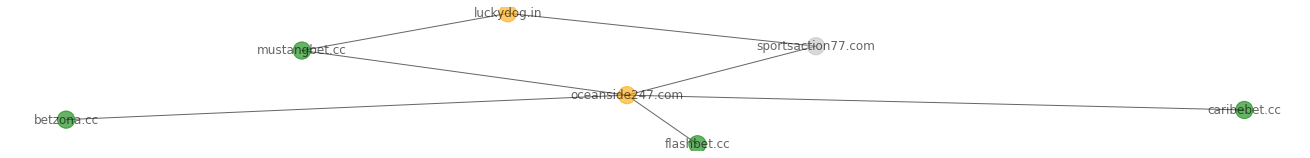

In [1170]:
colorGraph(2)

### WHO OWNS THESE SITES?

Running these sites through DomainBigData, and charting them into the network visualisation.

In [1171]:
identifiers_d = {}
for site in checklist:
    s = site.replace('https','').replace('http','').replace('://','').replace('www.','').replace('/','')
    identifiers_d[s] = {}
    DBDsites(site,s)
identifiersDF = pd.DataFrame.from_dict(identifiers_d).T
identifiersDF['Site'] = identifiersDF.index               ## makes the network analysis easier to refer to a clumn value, not an index value

https://domainbigdata.com/betzona.cc
https://domainbigdata.com/caribebet.cc
https://domainbigdata.com/flashbet.cc
https://domainbigdata.com/mustangbet.cc
https://domainbigdata.com/luckydog.in
https://domainbigdata.com/oceanside247.com
https://domainbigdata.com/sportsaction77.com


In [1172]:
## ONLY NEEDED THE FIRST TIME AROUND USUALLY. ADDS HISTORY 1 COLUMNS IF THEY ARENT IN THERE ALREADY
for item in ['Name', 'Org', 'Email', 'Phone']:
    addHistCols(item)

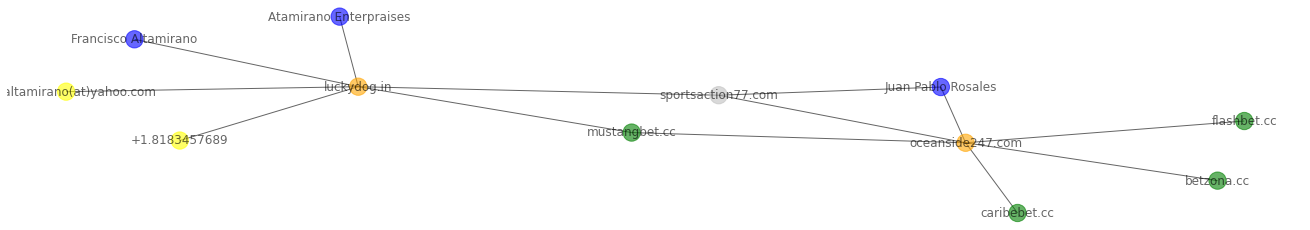

In [1173]:
for item in ['Registrant Name','Registrant Organisation','Registrant Email','Registrant Phone']:
    regNodes('Site',item)
    
for item in ['Historic Name 0','Historic Org 0','Historic Email 0','Historic Phone 0']:
    regNodes('Site',item)
    
for item in ['Historic Name 1','Historic Org 1','Historic Email 1','Historic Phone 1']:
    regNodes('Site',item)
    
colorGraph(3)

### EXPANDING THE NETWORK

Now that we know the names of the owners, we can see what others sites they own

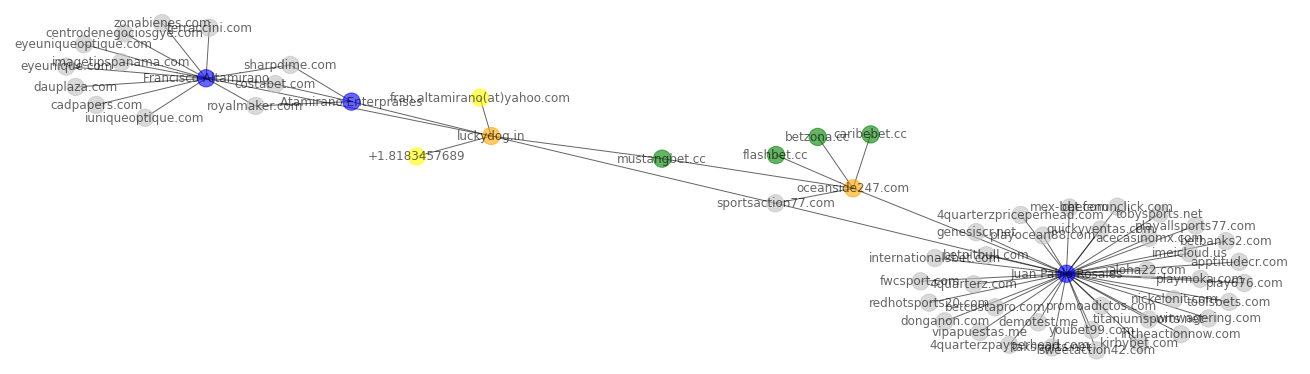

In [1174]:
for item in ['Registrant Name', 'Registrant Organisation', 'Historic Name 0', 'Historic Org 0', 'Historic Name 1','Historic Org 1']:
    ownerNodes(item + ' URL', item)

colorGraph(5)

### WHOIS???
Here are the contacts we have harvested so far. 
I have left repeats in, as they give some idea 

In [1175]:
list(np.unique(contact_list))

['+1.8183457689',
 'Atamirano Enterpraises',
 'Francisco Altamirano',
 'Juan Pablo Rosales',
 'fran.altamirano(at)yahoo.com']

# NOW RUN IT ALL OVER AGAIN

Now that you have expanded the list of websites to check, it's time to start this process over again.

In [1176]:
identifiers_d = {}
for site in checklist:
    s = site.replace('https','').replace('http','').replace('://','').replace('www.','').replace('/','')
    identifiers_d[s] = {}
    DBDsites(site,s)
identifiersDF = pd.DataFrame.from_dict(identifiers_d).T
identifiersDF['Site'] = identifiersDF.index               ## makes the network analysis easier to refer to a clumn value, not an index value

https://domainbigdata.com/betzona.cc
https://domainbigdata.com/caribebet.cc
https://domainbigdata.com/flashbet.cc
https://domainbigdata.com/mustangbet.cc
https://domainbigdata.com/luckydog.in
https://domainbigdata.com/oceanside247.com
https://domainbigdata.com/sportsaction77.com
https://domainbigdata.com/eyeunique.com
https://domainbigdata.com/royalmaker.com
https://domainbigdata.com/dauplaza.com
https://domainbigdata.com/imagetipspanama.com
https://domainbigdata.com/sharpdime.com
https://domainbigdata.com/luckydog.in
https://domainbigdata.com/eyeuniqueoptique.com
https://domainbigdata.com/terraccini.com
https://domainbigdata.com/zonabienes.com
https://domainbigdata.com/iuniqueoptique.com
https://domainbigdata.com/centrodenegociosgye.com
https://domainbigdata.com/costabet.com
https://domainbigdata.com/cadpapers.com
https://domainbigdata.com/apptitudecr.com
https://domainbigdata.com/genesiscr.net
https://domainbigdata.com/play676.com
https://domainbigdata.com/playallsports77.com
https:/

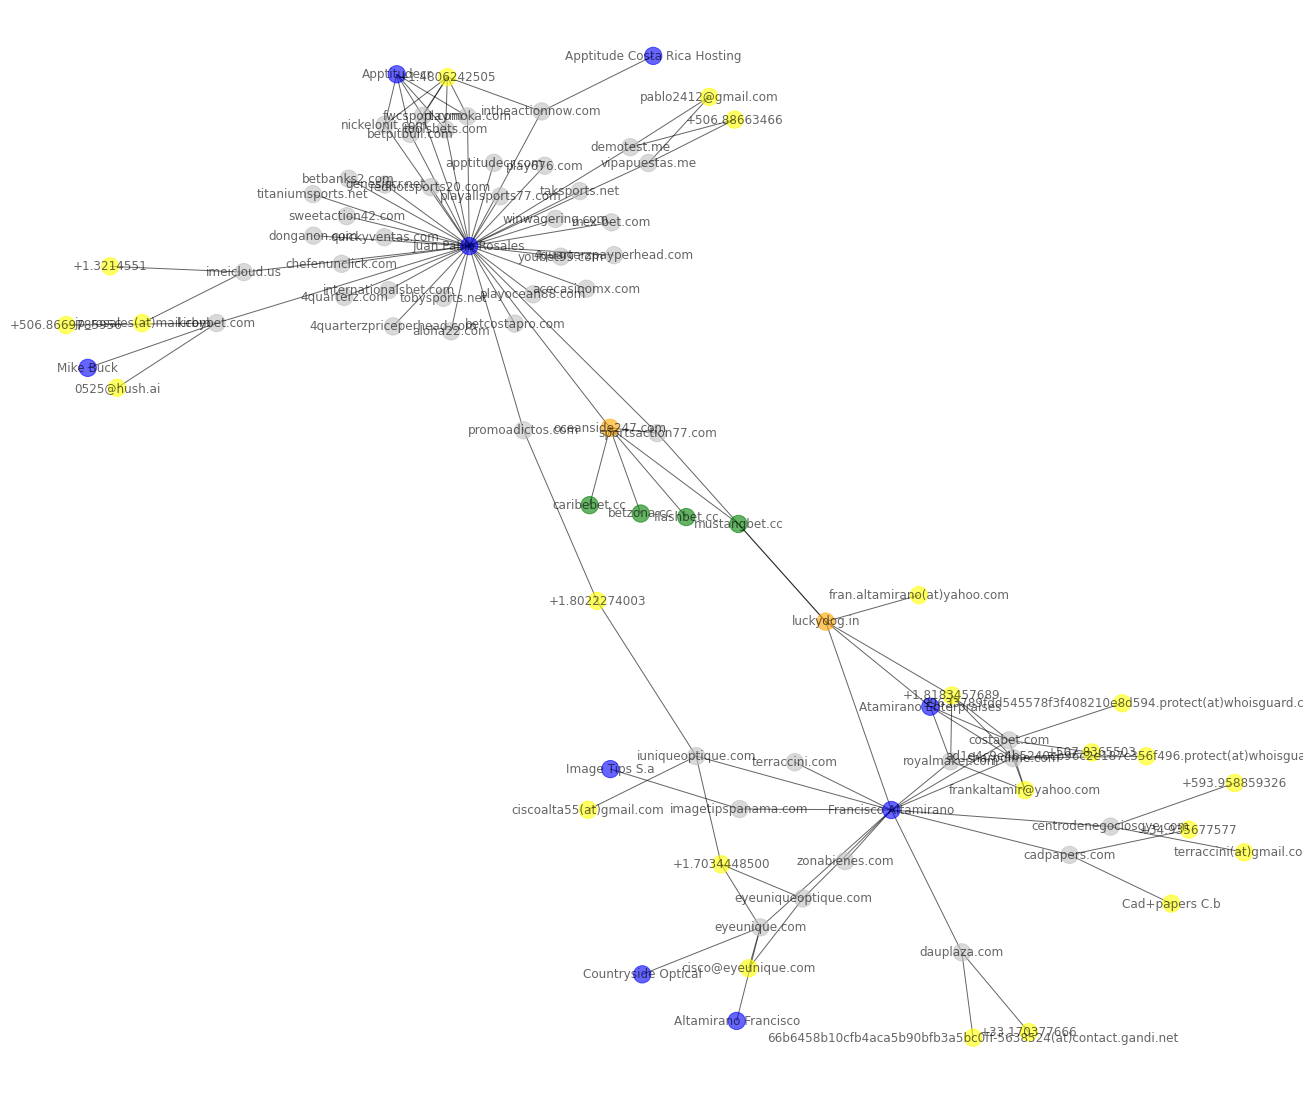

In [1177]:
#visualise
for item in ['Registrant Name','Registrant Organisation','Registrant Email','Registrant Phone']:
    regNodes('Site',item)
    
for item in ['Historic Name 0','Historic Org 0','Historic Email 0','Historic Phone 0']:
    regNodes('Site',item)
    
for item in ['Historic Name 1','Historic Org 1','Historic Email 1','Historic Phone 1']:
    regNodes('Site',item)

colorGraph(15)

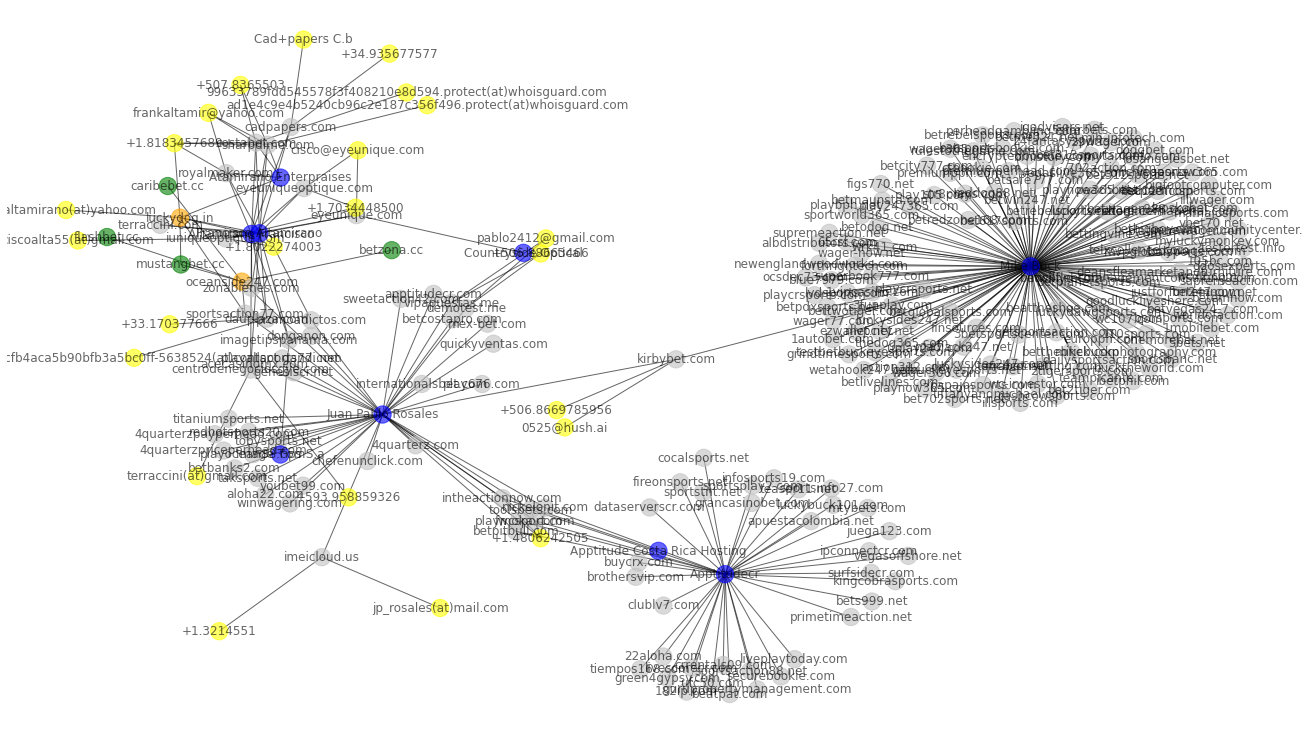

In [1178]:
for item in ['Registrant Name', 'Registrant Organisation', 'Historic Name 0', 'Historic Org 0', 'Historic Name 1','Historic Org 1']:
    ownerNodes(item + ' URL', item)

colorGraph(10)

In [1179]:
list(np.unique(contact_list))

['+1.3214551',
 '+1.4806242505',
 '+1.7034448500',
 '+1.8022274003',
 '+1.8183457689',
 '+33.170377666',
 '+34.935677577',
 '+506.8669785956',
 '+506.88663466',
 '+507.8365503',
 '+593.958859326',
 '0525@hush.ai',
 '66b6458b10cfb4aca5b90bfb3a5bc0ff-5638524(at)contact.gandi.net',
 '99633789fdd545578f3f408210e8d594.protect(at)whoisguard.com',
 'Altamirano Francisco',
 'Apptitude Costa Rica Hosting',
 'Apptitudecr',
 'Atamirano Enterpraises',
 'Cad+papers C.b',
 'Countryside Optical',
 'Francisco Altamirano',
 'Image Tips S.a',
 'Juan Pablo Rosales',
 'Mike Buck',
 'ad1e4c9e4b5240cb96c2e187c356f496.protect(at)whoisguard.com',
 'cisco@eyeunique.com',
 'ciscoalta55(at)gmail.com',
 'fran.altamirano(at)yahoo.com',
 'frankaltamir@yahoo.com',
 'jp_rosales(at)mail.com',
 'pablo2412@gmail.com',
 'terraccini(at)gmail.com']

## GO BESPOKE

From here, I would like to proceed with more caution - to stop it getting too messy, and because there are only a few end points that I would like to look at.

Find the node you want to add. Search for it in https://domainbigdata.com/ Once you get to the right page, copy the URL.

then past into this formula and copy below DBDowner(fieldURL, fieldNODE)

(fieldNODE has to equal the node you searching for)


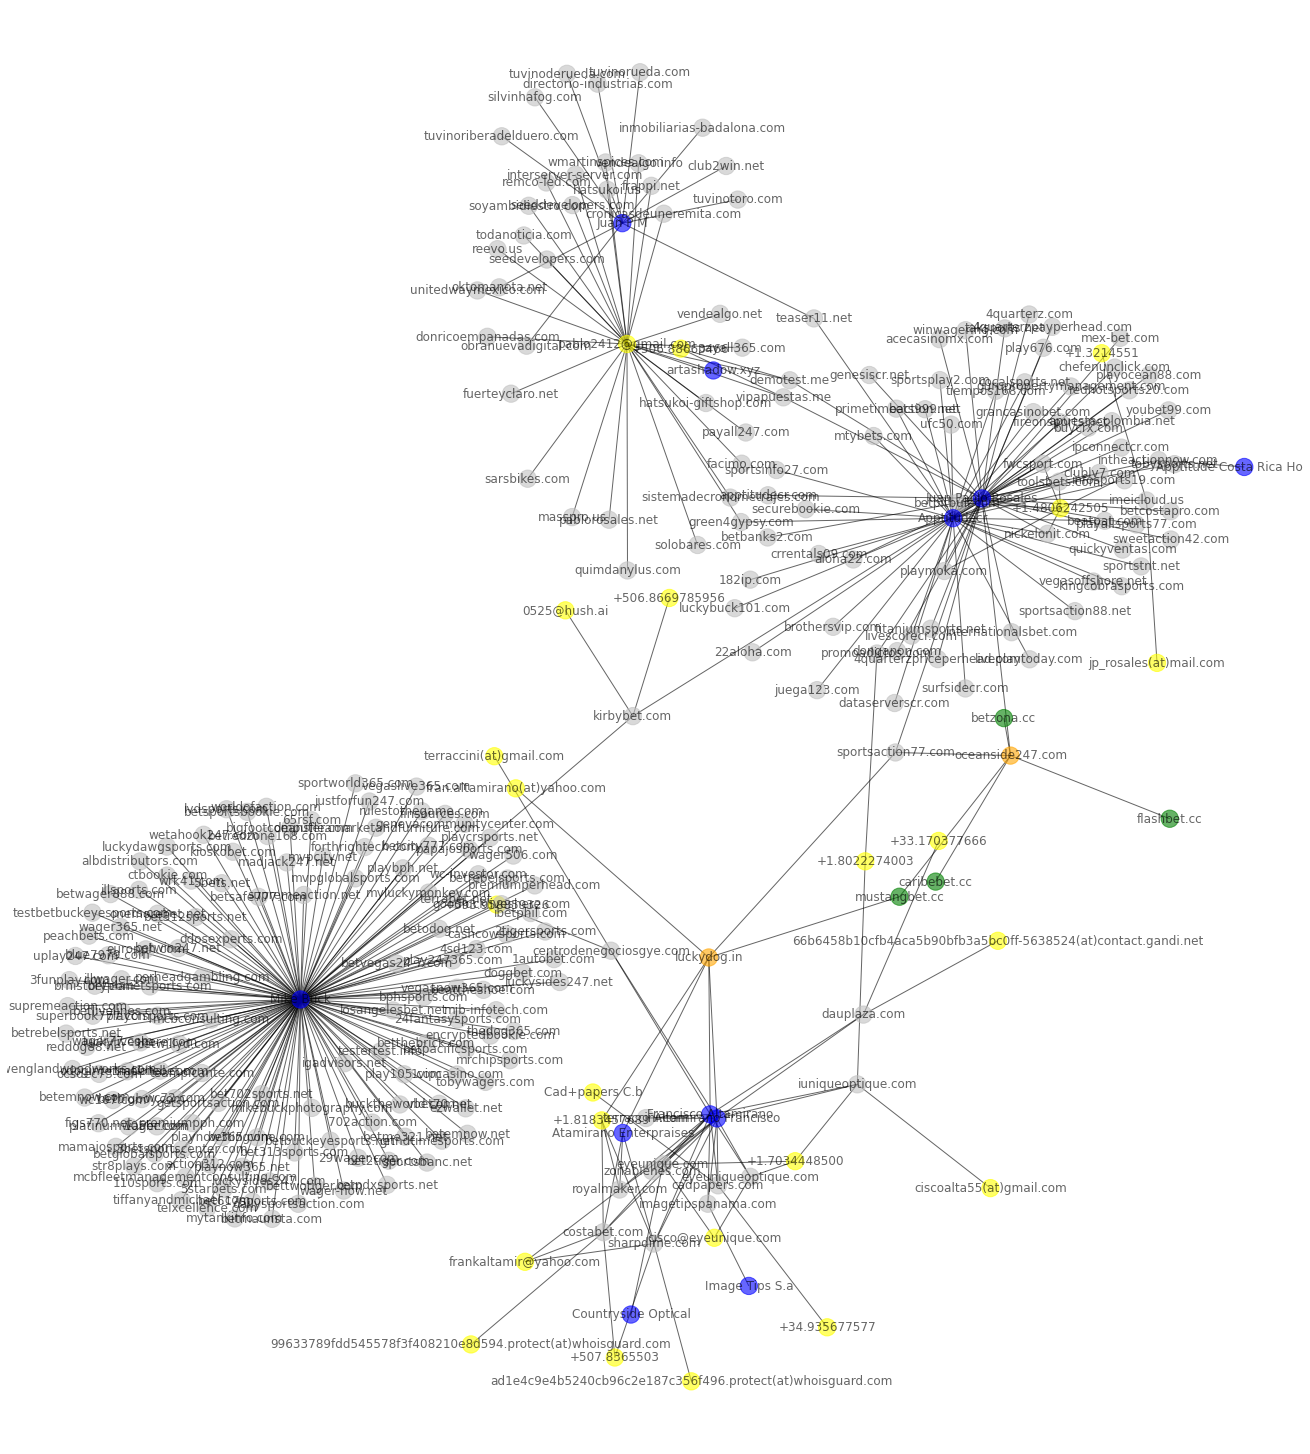

In [1180]:
DBDowner('https://domainbigdata.com/nj/Qxhz5u_t7Fn26Zza1YPgyw', 'Juan P M')

DBDowner('https://domainbigdata.com/nj/tUd3nzIhz9q9FWqIJj762w', 'pablo2412@gmail.com')

colorGraph(20)

Now we have a list of contacts we can use to try to find the owner of those sites we originally looked at. What seemed like a hopeless task can now be done in minutes.

In [1183]:
list(np.unique(contact_list))

['+1.3214551',
 '+1.4806242505',
 '+1.7034448500',
 '+1.8022274003',
 '+1.8183457689',
 '+33.170377666',
 '+34.935677577',
 '+506.8669785956',
 '+506.88663466',
 '+507.8365503',
 '+593.958859326',
 '0525@hush.ai',
 '66b6458b10cfb4aca5b90bfb3a5bc0ff-5638524(at)contact.gandi.net',
 '99633789fdd545578f3f408210e8d594.protect(at)whoisguard.com',
 'Altamirano Francisco',
 'Apptitude Costa Rica Hosting',
 'Apptitudecr',
 'Atamirano Enterpraises',
 'Cad+papers C.b',
 'Countryside Optical',
 'Francisco Altamirano',
 'Image Tips S.a',
 'Juan P M',
 'Juan Pablo Rosales',
 'Mike Buck',
 'ad1e4c9e4b5240cb96c2e187c356f496.protect(at)whoisguard.com',
 'artashadow.xyz',
 'cisco@eyeunique.com',
 'ciscoalta55(at)gmail.com',
 'fran.altamirano(at)yahoo.com',
 'frankaltamir@yahoo.com',
 'jp_rosales(at)mail.com',
 'pablo2412@gmail.com',
 'terraccini(at)gmail.com']